# ResNet Transfer Model Demo

In this notebook, we will show a basic evaluation of the trained resnet transfer model. 

First, we will go over the general training methodology. Then, we will move into a live evaluation.

This evaluation will include:
- **Overall Accuracy** giving us the percentage of correctly classified images.
- **Misclassified Images** so we can see which images tripped the model up.

# High-Level Model Training Overview

We started with a labeled dataset of images from YOLO object detecting format
Each image file had a corresponding label file, which contained coordinates for bounding boxes and a related label (i.e. 0 or 1, bad or good weld)

First, we split the data into training, validation, and testing folders. 
Next, we used a pretrained ResNet as our base model, then added a final layer to output the number of classes we desired for our data (currently two)
                                                                                                                        
For the training, we fed batches of labeled images into the model and computed a loss to compare the predictions to the actual labels.
By iterating over the dataset for ten full passes over the data (ten epochs) we achieved satisfactory accuracy and overall generalization.


## Evaluation Setup

First we will import the libraries we need and define the device, load the test dataset, then setup the model for evaluation

In [3]:
import os
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from collections import Counter
from PIL import Image

%matplotlib inline 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device) 

# Here we will make sure all the images are 640x640, then convert them to tensors (which are like multidimensional arrays)
test_transform = transforms.Compose([
    transforms.Resize((640, 640)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

data_dir = "Separated_Dataset" 
test_dir = os.path.join(data_dir, "test")

test_dataset = torchvision.datasets.ImageFolder(root=test_dir, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False) 

print("Test data size:", len(test_dataset))

Using device: cpu
Test data size: 36


## Load Model

We create a resnet18 model and freeze its layers except the final one. Next, we load the saved weights and set it to evaluation mode.

In [4]:
import torchvision.models as models

resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
# disable gradient updates, makes it where pretrained weights wont change during training
for param in resnet.parameters():
    param.requires_grad = False
in_features = resnet.fc.in_features

# replace original final connected layer with new one, 2 outputs (binary classification)
resnet.fc = nn.Linear(in_features, 2)

resnet = resnet.to(device)

# load the saved weights
model_path = "resnet_model.pth" 
if not os.path.exists(model_path):
    raise FileNotFoundError(f"Model file '{model_path}' not found.")

resnet.load_state_dict(torch.load(model_path))
resnet.eval()
print("Model loaded, set to eval mode.")

Model loaded, set to eval mode.


## Create Predictions

Now we run the model on all files in the test dataset

In [6]:
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device) 

        # pass through resnet model
        outputs = resnet(images) 

        # saves highest score (one for each class)
        _, preds = torch.max(outputs, 1)

        # store predicted and actual labels
        all_preds.extend(preds.cpu().numpy()) 
        all_labels.extend(labels.numpy())

print("Run complete.")

Run complete.


## Results
Here's a look at the numbers, followed by a simple chart.

Total images in test: 36
Correctly classified image: 31
Misclassified images: 5
Overall Accuracy: 86.11%

Predicted Counts:
 Bad_Weld: 17
 Good_Weld: 19

Actual Counts:
 Bad_Weld: 14
 Good_Weld: 22


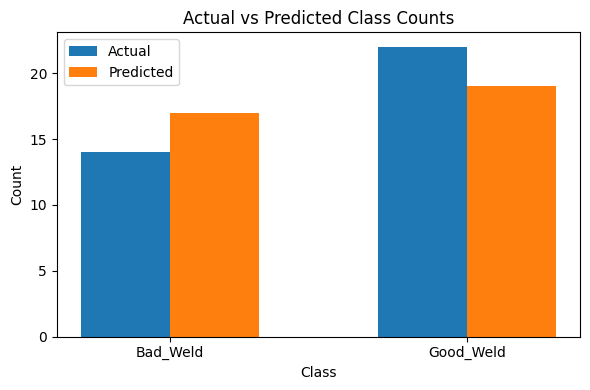

In [7]:
total_test = len(all_labels)
correct_test = sum(p == a for p, a in zip(all_preds, all_labels))
accuracy = 100.0 * correct_test / total_test

print(f"Total images in test: {total_test}")
print(f"Correctly classified image: {correct_test}")
print(f"Misclassified images: {total_test - correct_test}")
print(f"Overall Accuracy: {accuracy:.2f}%")

class_names = test_dataset.classes
# Convert class_names to readable names
actual_labels = [class_names[a] for a in all_labels]
predicted_labels = [class_names[p] for p in all_preds]

actual_counts = Counter(actual_labels)
predicted_counts = Counter(predicted_labels)

fig, ax = plt.subplots(figsize=(6,4))
index = range(len(class_names))
bar_width = 0.3

actual_vals = [actual_counts[c] for c in class_names]
predicted_vals = [predicted_counts[c] for c in class_names] 

print("\nPredicted Counts:")
for c in class_names:
    print(f" {c}: {predicted_counts[c]}")

print("\nActual Counts:")
for c in class_names:
    print(f" {c}: {actual_counts[c]}")

ax.bar(index, actual_vals, bar_width, label='Actual')
ax.bar([i + bar_width for i in index], predicted_vals, bar_width, label='Predicted')

ax.set_xticks([i + bar_width/2 for i in index])
ax.set_xticklabels(class_names)

ax.set_title('Actual vs Predicted Class Counts')
ax.set_xlabel('Class')
ax.set_ylabel('Count')
ax.legend()

plt.tight_layout()
plt.show()

## Misclassified Image List

Finally, let's look at the images that were misclassified:

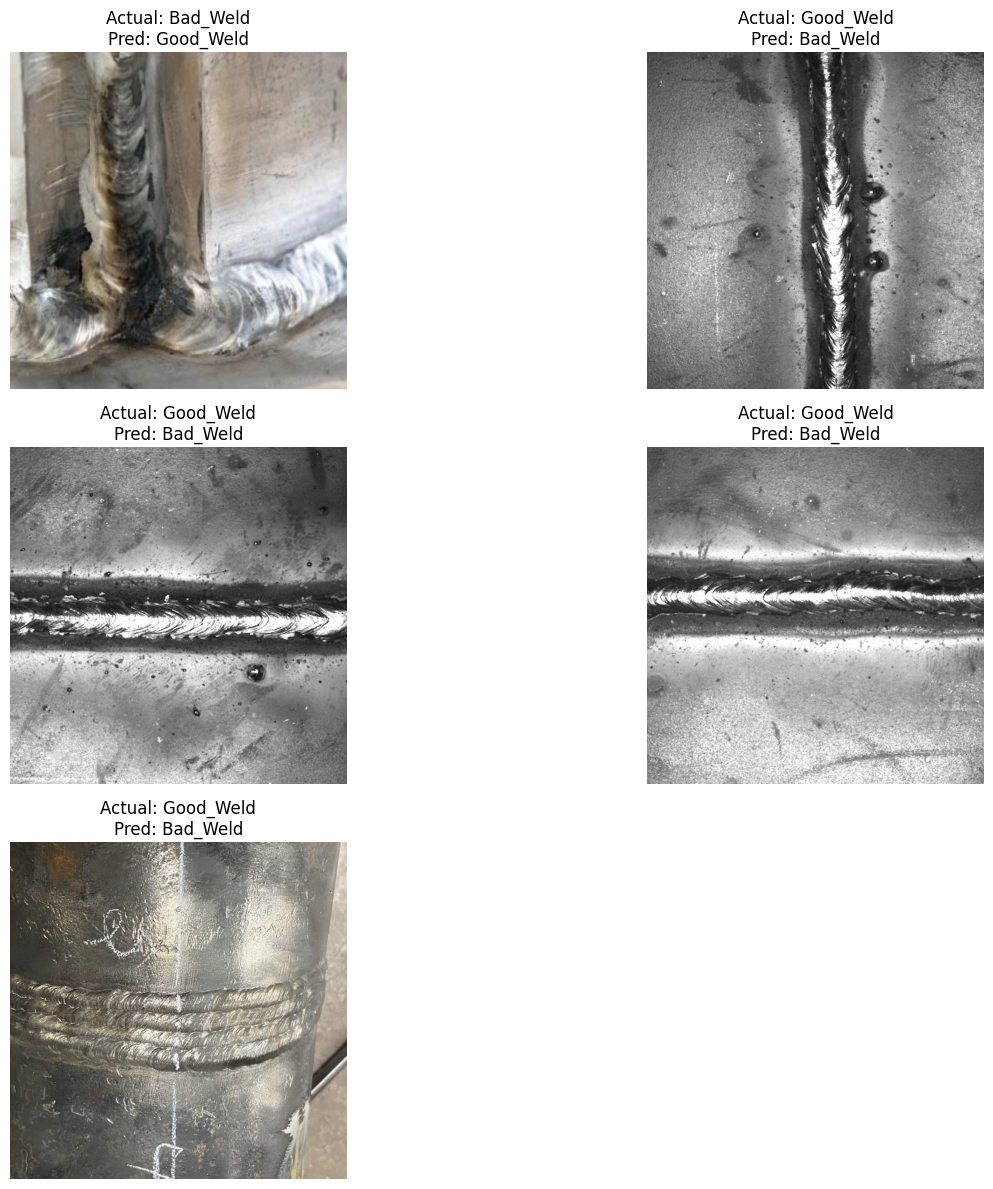

In [9]:
misclassified = []

for i, (img_path, label_idx) in enumerate(test_dataset.samples):
    if all_preds[i] != label_idx:
        misclassified.append((img_path, label_idx, all_preds[i]))

if misclassified:
    n_images = len(misclassified)
    n_cols = 2
    n_rows = (n_images + n_cols - 1) // n_cols
    
    plt.figure(figsize=(14, n_rows*4))

    for idx, (img_path, actual_idx, pred_idx) in enumerate(misclassified):
        img = Image.open(img_path).convert('RGB')
        plt.subplot(n_rows, n_cols, idx+1)
        plt.imshow(img)
        plt.title(f"Actual: {class_names[actual_idx]}\nPred: {class_names[pred_idx]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("No misclassified images found.")